In [1]:
import glob
import os
import numpy as np
import datetime
from netCDF4 import Dataset
import scipy.io
import h5py
from pyproj import Proj, Transformer
import cartopy.crs as ccrs
from scipy.spatial.kdtree import KDTree
import scipy.stats as scst
#from regrid import regrid
#from regrid import regrid_fast
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
#import cartopy
import warnings
warnings.filterwarnings("ignore")
import re
#import temporel #, InversionBinnedParallel



/tmp/ipykernel_213802/2413993182.py:10: DeprecationWarning: Please import `KDTree` from the `scipy.spatial` namespace; the `scipy.spatial.kdtree` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.spatial.kdtree import KDTree


In [2]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion



In [4]:
def lonlat_to_xy(coords_1, coords_2, hemisphere, inverse=False):

    """Converts between longitude/latitude and EASE xy coordinates.
 
    Args:
        lon (float): WGS84 longitude
        lat (float): WGS84 latitude
        hemisphere (string): 'n' or 's'
        inverse (bool): if true, converts xy to lon/lat
 
    Returns:
        tuple: pair of xy or lon/lat values
    """

    EASE_Proj = {'n': 'EPSG:3408',
                 's': 'EPGS:3409'}
    
    WGS_Proj = 'EPSG:4326'
    
    #for coords in [coords_1, coords_2]: assert isinstance(coords,(np.ndarray,list))

    if inverse == False: # lonlat to xy
        
        lon, lat = coords_1, coords_2
        
        transformer = Transformer.from_crs(WGS_Proj, EASE_Proj[hemisphere])
        
        x, y = transformer.transform(lat, lon)
        
        return (x, y)

    else: # xy to lonlat
        
        x, y = coords_1, coords_2
        
        transformer = Transformer.from_crs(EASE_Proj[hemisphere], WGS_Proj)
        
        lat, lon = transformer.transform(x, y)
        
        return (lon, lat)

In [8]:
def process_file(filepath):
    # Charger les données du fichier
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 3:
                try:
                    data.append([float(part) for part in parts])
                except ValueError:
                    continue  # Ignorer les lignes qui ne peuvent pas être converties en float
    
    data = np.array(data)
    
    X = data[:,0]
    Y = data[:,1]
    values = data[:, 2]

    return values, X, Y


input_directory = '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/'
output_directory = '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/intermediate_models/'

# Expression régulière pour filtrer les noms de fichiers
file_snow = r'20190414.npy_snowinter\.txt\.A-\d+'
file_penetration = r'20190414.npy_penetrationinter\.txt\.C-\d+'
file_ice = r'20190414.npy_iceinter\.txt\.B-\d+'

# Liste pour stocker les chemins des fichiers correspondants au modèle
file_paths_snow = []
file_paths_penetration = []
file_paths_ice = []

# Boucler sur les fichiers dans le répertoire

for filename in os.listdir(input_directory):
    filepath = os.path.join(input_directory, filename)
    # Vérifier si le nom de fichier correspond au modèle
    if re.match(file_snow, filename):
        file_paths_snow.append(filepath)

for filename in os.listdir(input_directory):
    filepath = os.path.join(input_directory, filename)
    # Vérifier si le nom de fichier correspond au modèle
    if re.match(file_penetration, filename):
        file_paths_penetration.append(filepath)

for filename in os.listdir(input_directory):
    filepath = os.path.join(input_directory, filename)
    # Vérifier si le nom de fichier correspond au modèle
    if re.match(file_ice, filename):
        file_paths_ice.append(filepath)


# Assurer que le répertoire de sortie existe
os.makedirs(output_directory, exist_ok=True)

snow_value, snow_x, snow_y = [], [], []
ice_value, ice_x, ice_y = [], [], []
penetration_value, penetration_x, penetration_y = [], [], []

# Traiter chaque fichier trouvé
for i in range(0, len(file_paths_snow), 100):
    print(f"Processing file {i+1}/{len(file_paths_snow)}: {file_paths_snow[i]}")
    snow_value.append(process_file(file_paths_snow[i])[0])
    penetration_value.append(process_file(file_paths_penetration[i])[0])
    ice_value.append(process_file(file_paths_ice[i])[0])

    snow_x.append(process_file(file_paths_snow[i])[1])
    penetration_x.append(process_file(file_paths_penetration[i])[1])
    ice_x.append(process_file(file_paths_penetration[i])[1])

    snow_y.append(process_file(file_paths_snow[i])[2])
    penetration_y.append(process_file(file_paths_penetration[i])[2])
    ice_y.append(process_file(file_paths_penetration[i])[2])


Processing file 1/18001: /home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/20190414.npy_snowinter.txt.A-0000000001
Processing file 101/18001: /home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/20190414.npy_snowinter.txt.A-0000000101
Processing file 201/18001: /home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/20190414.npy_snowinter.txt.A-0000000297
Processing file 301/18001: /home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/20190414.npy_snowinter.txt.A-0000000219
Processing file 401/18001: /home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/20190414.npy_snowinter.txt.A-0000000495
Processing file 501/18001: /home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/20190414.npy_snowinter.txt.A-0000000415
Processing file 601/18001: /home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/20190414.npy_snowinter.txt.A-0000000695
Processing file 701/18001: /home/erb/master

In [88]:
import numpy as np
from scipy.spatial import KDTree


x_ease = np.load('/home/erb/masterproject/MSCI_project/new_x_25km.npy')
y_ease = np.load('/home/erb/masterproject/MSCI_project/new_y_25km.npy')

# Fonction pour charger les données d'un fichier .txt
def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 3:
                try:
                    data.append([float(part) for part in parts])
                except ValueError:
                    continue  # Ignorer les lignes qui ne peuvent pas être converties en float
    return np.array(data)



def nearest(file1, file2, file3, x_ease, y_ease) : 
#file1 = '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/20190414.npy_snowinter.txt.A-0000017042'
#file2 = '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/20190414.npy_iceinter.txt.B-0000017042'
#file3 = '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/20190414.npy_penetrationinter.txt.C-0000017042'

    data1 = load_data(file1)
    data2 = load_data(file2)
    data3 = load_data(file3)

    coords_ease = []

    for i in range(len(x_ease)):
        for j in range(len(y_ease)):
            coords_ease.append((x_ease[i][j]/1000000, y_ease[i][j]/1000000))

# Extraire les coordonnées et les valeurs
    coords1, values1 = data1[:, :2], data1[:, 2]
    coords2, values2 = data2[:, :2], data2[:, 2]
    coords3, values3 = data3[:, :2], data3[:, 2]

# Construire les KD-trees pour les fichiers 2 et 3
    tree1 = KDTree(coords1)
    tree2 = KDTree(coords2)
    tree3 = KDTree(coords3)

# Trouver les plus proches voisins pour chaque point de coords1
    nearest_indices1 = tree1.query(coords_ease)[1]
    nearest_indices2 = tree2.query(coords_ease)[1]
    nearest_indices3 = tree3.query(coords_ease)[1]

# Extraire les valeurs des plus proches voisins
    nearest_values2 = values2[nearest_indices2]
    nearest_values3 = values3[nearest_indices3]

# Stocker les résultats dans une liste
    results = []
    for i, (coord, value1, nearest_value2, nearest_value3) in enumerate(zip(coords_ease, values1, nearest_values2, nearest_values3)):
        results.append({
            'coordinate': (coord[0], coord[1]),
            'value1': value1,
            'nearest_value2': nearest_value2,
            'nearest_value3': nearest_value3
        })

    return results


input_directory = '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/images/'

file_pattern_snow = r'20190414.npy_snowinter\.txt\.A-\d+'
file_pattern_ice = r'20190414.npy_iceinter\.txt\.B-\d+'
file_pattern_penetration = r'20190414.npy_penetrationinter\.txt\.C-\d+'

file_paths_snow, file_paths_ice, file_paths_penetration = [], [], []

# Boucler sur les fichiers dans le répertoire
for filename in os.listdir(input_directory):
    filepath = os.path.join(input_directory, filename)
    # Vérifier si le nom de fichier correspond au modèle
    if re.match(file_pattern_snow, filename):
        file_paths_snow.append(filepath)

for filename in os.listdir(input_directory):
    filepath = os.path.join(input_directory, filename)
    # Vérifier si le nom de fichier correspond au modèle
    if re.match(file_pattern_penetration, filename):
        file_paths_penetration.append(filepath)

for filename in os.listdir(input_directory):
    filepath = os.path.join(input_directory, filename)
    # Vérifier si le nom de fichier correspond au modèle
    if re.match(file_pattern_ice, filename):
        file_paths_ice.append(filepath)

nearest_value = []

# Traiter chaque fichier trouvé
for i in range(0, len(file_paths_snow), 10000):
    nearest_value.append(nearest(file_paths_snow[i], file_paths_ice[i], file_paths_penetration[i], x_ease, y_ease))


# Passage de x,y à lon, lat 
#for sublist in nearest_value:
    #for entry in sublist:
    #    x, y = entry['coordinate']
        #x,y  = x*1000000, y*1000000
    #    lon, lat = lonlat_to_xy(x, y, "n", True)
    #    entry['coordinate'] = (lon, lat)


In [74]:
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

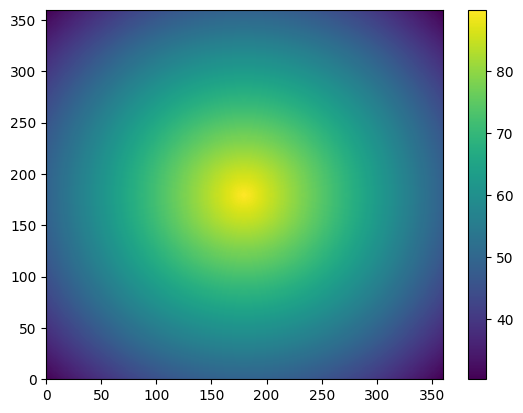

In [91]:
plt.pcolor(lat_g)
plt.colorbar()

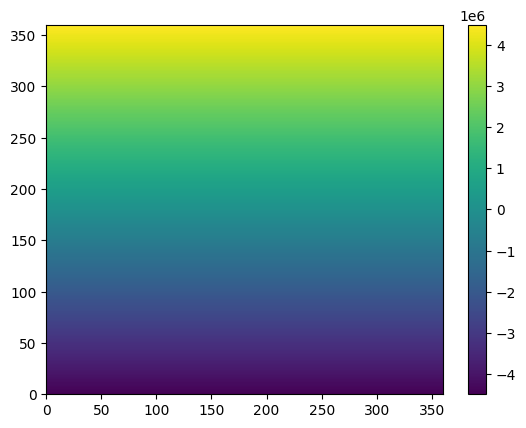

In [79]:
plt.pcolor(y_ease)
plt.colorbar()

In [89]:
nearest_value

[[{'coordinate': (-4.4875, -4.4875),
   'value1': 0.1346213046,
   'nearest_value2': 5.767451094,
   'nearest_value3': 1.060997418},
  {'coordinate': (-4.4625, -4.4875),
   'value1': 0.37566782,
   'nearest_value2': 5.767451094,
   'nearest_value3': 1.060997418},
  {'coordinate': (-4.4375, -4.4875),
   'value1': 0.311924174,
   'nearest_value2': 5.767451094,
   'nearest_value3': 1.060997418},
  {'coordinate': (-4.4125, -4.4875),
   'value1': 0.05775777214,
   'nearest_value2': 5.767451094,
   'nearest_value3': 1.060997418},
  {'coordinate': (-4.3875, -4.4875),
   'value1': 0.4943721745,
   'nearest_value2': 5.767451094,
   'nearest_value3': 1.060997418},
  {'coordinate': (-4.3625, -4.4875),
   'value1': 0.009018924979,
   'nearest_value2': 5.767451094,
   'nearest_value3': 1.060997418},
  {'coordinate': (-4.3375, -4.4875),
   'value1': 0.499558063,
   'nearest_value2': 5.767451094,
   'nearest_value3': 1.060997418},
  {'coordinate': (-4.3125, -4.4875),
   'value1': 0.03292864207,
   'n

In [56]:
snow = []
ice = []
penetration = []


for sublist in nearest_value:
    snow.append(sublist[5]['value1'])
    penetration.append(sublist[5]['nearest_value3'])
    ice.append(sublist[5]['nearest_value2'])


Text(0, 0.5, 'snow')

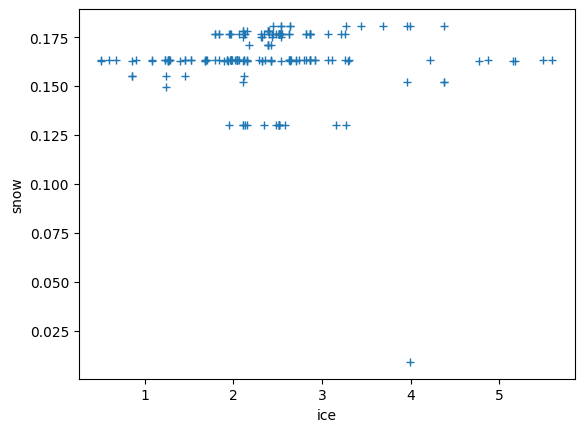

In [57]:
plt.plot(ice, snow, '+')
plt.xlabel('ice')
plt.ylabel('snow')

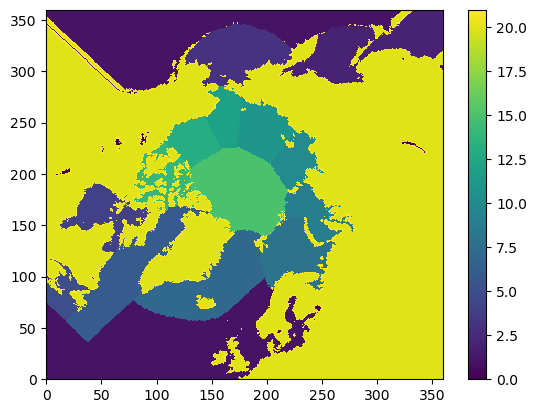

In [30]:
NSIDC = np.load('/home/erb/masterproject/MSCI_project/snow_ice/carmen/NSIDC_Regions_Mask.npy')
plt.pcolor(NSIDC)
plt.colorbar()